# Baseline модель

- В качестве самой базовой модели была выбрана линейная регрессия без кросс-валидации и подбора гипер параметров. (обучение идет на полном наборе для белых и для черных)
- Так как достаточно быстро обучается есть возможность попробовать разные варианты обучения:
    1. Обучение только на победах белых -> прогноз ретйтинга белых
    2. Обучние только на победах черных -> прогноз ретйинга черных
    3. Обучение на ничьих -> прогноз рейтинга белых
    4. Обучение на ничьих -> прогноз рейтинга черных
    5. Обучение только на проигрышах белых -> прогноз рейтинга белых
    6. Обучение только на проигрышах черных -> прогноз рейтинга белых
    ### НЕ ДОДЕЛАНО
    7. Объединение/усреднение моделей
    
    
    8. Обучение на среднем ЭЛО
    9. Обучение на разнице ЭЛО
    10. Обучение на сумме ЭЛО

### Некоторые выводы:
- Обучение на разных результатах действительно имеет некоторое преимущество в оценке MAE. 
        (Но это относится только к выигрышам! Модели на проигрышах показывают плохой результат.)
- Обучение на разных функциях от рейтингов - еще эффективнее.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn import model_selection as ms
from scipy.stats import pearsonr

from warnings import simplefilter

rand_st=4
simplefilter("ignore") 

In [2]:
elos=pd.read_csv(r'C:\Users\Asus\PredictingRatings\data\clean_elos.csv')
elos.head()

,WhiteElo,BlackElo,MeanElos,DiffElos,SumElos
0,2354,2411,2382,57,4765
1,1915,1999,1957,84,3914
2,2446,2191,2318,255,4637
3,2168,2075,2121,93,4243
4,2437,2254,2345,183,4691


In [3]:
features=pd.read_csv(r'C:\Users\Asus\PredictingRatings\data\features.csv')
print(features.info())
print(features.shape)
features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24255 entries, 0 to 24254
Columns: 233 entries, Result to InsufficientMaterial
dtypes: float64(111), int64(122)
memory usage: 43.1 MB
None
(24255, 233)


,Result,NumMoves,MeanScore,ModeScore,FinalScore,FullMoves,MinScore,MaxScore,MedianScore,StdScore,...,EndB,EndR,EndK,WhiteСhecks,WhiteQueenCastle,BlackQueenCastle,Promotion,EnPassant,CanClaimDraw,InsufficientMaterial
count,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,...,24255.000000,24255.00000,24255.0,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000
mean,0.544877,42.252690,30.881103,11.907442,111.901711,83.967223,-794.591878,988.643950,68.913894,314.678490,...,0.631293,1.03892,1.0,2.015584,1.457308,0.910740,0.064069,0.061637,0.035415,0.000783
std,0.417736,16.235593,233.709202,445.214702,2310.851869,32.489872,2126.099646,2275.840558,64.170646,475.478471,...,0.676858,0.74847,0.0,2.874868,4.179615,3.663225,0.291749,0.245589,0.184831,0.027978
min,0.000000,10.000000,-2162.262500,-11447.000000,-12261.000000,19.000000,-12348.000000,-51.000000,0.000000,7.795716,...,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,-60.758665,0.000000,-362.000000,61.000000,-482.000000,67.000000,30.000000,61.336328,...,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,40.000000,24.563636,0.000000,0.000000,79.000000,-75.000000,156.000000,49.000000,145.621548,...,1.000000,1.00000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,51.000000,123.987715,26.000000,546.500000,102.000000,-18.000000,700.000000,84.000000,291.317992,...,1.000000,2.00000,1.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,165.000000,2073.289256,11259.000000,12337.000000,329.000000,26.000000,12352.000000,784.000000,3962.575036,...,2.000000,2.00000,1.0,71.000000,35.000000,36.000000,4.000000,2.000000,1.000000,1.000000


In [4]:
target_white=elos['WhiteElo']
target_black=elos['BlackElo']
target_mean=elos['MeanElos']
target_diff=elos['DiffElos']
target_sum=elos['SumElos']

In [5]:
start = time.time()
lrw = LinearRegression()
lrb = LinearRegression()
lrw.fit(features, target_white)
lrb.fit(features, target_black)
white_pred = lrw.predict(features)
black_pred = lrb.predict(features)
full_time=round((time.time() - start)/2,3)
print(full_time, 'c')

0.362 c


In [6]:
print('Для белых:')
maew=mae(target_white,white_pred)
print ('MAE = {:.3f}'.format(maew))
rmsew = (mse(target_white, white_pred))**0.5
print ('RMSE = {:.3f}'.format(rmsew))
corr_coefw = pearsonr(target_white, white_pred)
print("Correlation coefficient = {:.3f}".format(corr_coefw[0]))
print('\nДля черных:')
maeb=mae(target_black,black_pred)
print ('MAE = {:.3f}'.format(maeb))
rmseb = (mse(target_black,black_pred))**0.5
print ('RMSE = {:.3f}'.format(rmseb))
corr_coefb = pearsonr(target_black, black_pred)
print("Correlation coefficient = {:.3f}".format(corr_coefb[0]))

Для белых:
MAE = 186.539
RMSE = 234.559
Correlation coefficient = 0.486

Для черных:
MAE = 189.358
RMSE = 237.420
Correlation coefficient = 0.483


In [7]:
output = pd.DataFrame([[str(lrw), maew,rmsew, corr_coefw[0],full_time,'Обучение на полном набооре -> прогноз рейтингов белых'],
                      [str(lrb), maeb,rmseb, corr_coefb[0],full_time,'Обучение на полном набооре -> прогноз рейтингов черных']],
                   columns=['Модель', 'MAE','RMSE','Коэффициент корр. Пирсона', 'Время работы (c)', 'Комментарий'])

output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 1. Обучение только на победах белых -> прогноз ретйтинга белых

In [8]:
start1 = time.time()
lr_1 = LinearRegression()
features_white = features[features['Result']==1]
target_white1=target_white[target_white.index.isin(features_white.index)]
print(features_white.shape)
print(target_white1.shape)
lr_1.fit(features_white, target_white1)
white_pred1 = lr_1.predict(features_white)
full_time1=round(time.time() - start1,3)
print(full_time1, 'c')

(9651, 233)
(9651,)
0.153 c


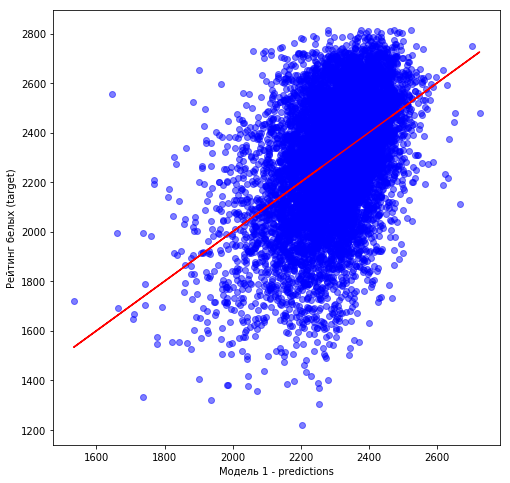

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(white_pred1,target_white1, color = 'b',alpha=0.5)
plt.xlabel('Модель 1 - predictions')
plt.ylabel('Рейтинг белых (target)')
# Линия тренда
z = np.polyfit(white_pred1,target_white1, 1)
p = np.poly1d(z)
plt.plot(white_pred1,p(white_pred1),"r")
plt.show()

In [10]:
mae1=mae(target_white1,white_pred1)
print ('MAE = {:.3f}'.format(mae1))
rmse1 = (mse(target_white1, white_pred1))**0.5
print ('RMSE = {:.3f}'.format(rmse1))
corr_coef1 = pearsonr(target_white1, white_pred1)
print("Correlation coefficient = {:.3f}".format(corr_coef1[0]))

MAE = 175.594
RMSE = 221.354
Correlation coefficient = 0.454


In [11]:
output = output.append(pd.Series([str(lr_1), mae1,rmse1, 
                                  corr_coef1[0],full_time1,'Обучение только на победах белых -> прогноз ретйтинга белых'],
                                 index=output.columns ),
                      ignore_index=True)

output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...


In [12]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 2. Обучение только на победах черных -> прогноз ретйтинга черных

In [13]:
start2 = time.time()
lr_2 = LinearRegression()
features_black = features[features['Result']==0]
target_black2=target_black[target_black.index.isin(features_black.index)]
print(features_black.shape)
print(target_black2.shape)
lr_2.fit(features_black, target_black2)
black_pred2 = lr_2.predict(features_black)
full_time2=round(time.time() - start2,3)
print(full_time2, 'c')

(7474, 233)
(7474,)
0.216 c


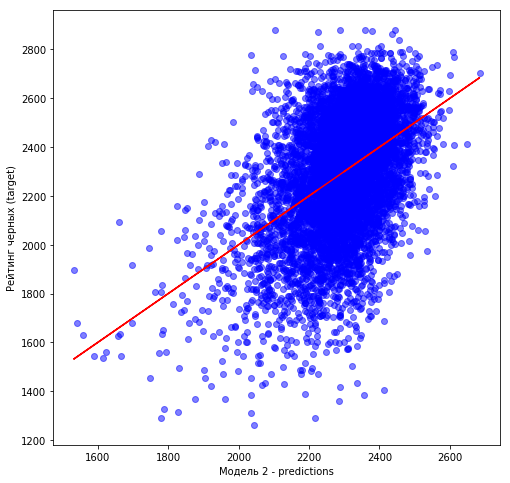

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(black_pred2,target_black2, color = 'b',alpha=0.5)
plt.xlabel('Модель 2 - predictions')
plt.ylabel('Рейтинг черных (target)')
# Линия тренда
z = np.polyfit(black_pred2,target_black2, 1)
p = np.poly1d(z)
plt.plot(black_pred2,p(black_pred2),"r")
plt.show()

In [15]:
mae2=mae(target_black2,black_pred2)
print ('MAE = {:.3f}'.format(mae2))
rmse2 = mse(target_black2, black_pred2)**0.5
print ('RMSE = {:.3f}'.format(rmse2))
corr_coef2 = pearsonr(target_black2, black_pred2)
print("Correlation coefficient = {:.3f}".format(corr_coef2[0]))

MAE = 176.326
RMSE = 221.767
Correlation coefficient = 0.462


In [16]:
output = output.append(pd.Series([str(lr_2), mae2, rmse2, corr_coef2[0],
                                  full_time2,'Обучение только на победах черных -> прогноз ретйтинга черных'], index=output.columns ),
                      ignore_index=True)
output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...


In [17]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 3. Обучение только на ничьих -> прогноз ретйтинга белых

In [18]:
start3 = time.time()
lr_3 = LinearRegression()
features_draw = features[features['Result']==0.5]
target_white3=target_white[target_white.index.isin(features_draw.index)]
print(features_draw.shape)
print(target_white3.shape)
lr_3.fit(features_draw, target_white3)
white_pred3 = lr_3.predict(features_draw)
full_time3=round(time.time() - start3,3)
print(full_time3, 'c')

(7130, 233)
(7130,)
0.137 c


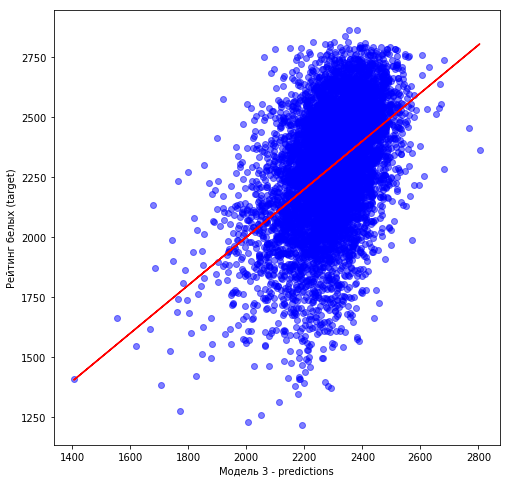

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(white_pred3,target_white3, color = 'b',alpha=0.5)
plt.xlabel('Модель 3 - predictions')
plt.ylabel('Рейтинг белых (target)')
# Линия тренда
z = np.polyfit(white_pred3,target_white3, 1)
p = np.poly1d(z)
plt.plot(white_pred3,p(white_pred3),"r")
plt.show()

In [20]:
mae3=mae(target_white3,white_pred3)
print ('MAE = {:.3f}'.format(mae3))
rmse3 = mse(target_white3, white_pred3)**0.5
print ('RMSE = {:.3f}'.format(rmse3))
corr_coef3 = pearsonr(target_white3, white_pred3)
print("Correlation coefficient = {:.3f}".format(corr_coef3[0]))

MAE = 177.432
RMSE = 224.595
Correlation coefficient = 0.465


In [21]:
output = output.append(pd.Series([str(lr_3), mae3, rmse3, corr_coef3[0],
                                  full_time3,'Обучение только на ничьих -> прогноз ретйтинга белых'], index=output.columns ),
                      ignore_index=True)
output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...


In [22]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 4. Обучение только на ничьих -> прогноз ретйтинга черных

In [23]:
start4 = time.time()
lr_4 = LinearRegression()
features_draw = features[features['Result']==0.5]
target_black4=target_black[target_black.index.isin(features_draw.index)]
print(features_draw.shape)
print(target_black4.shape)
lr_4.fit(features_draw, target_black4)
black_pred4 = lr_4.predict(features_draw)
full_time4=round(time.time() - start4,3)
print(full_time4, 'c')

(7130, 233)
(7130,)
0.144 c


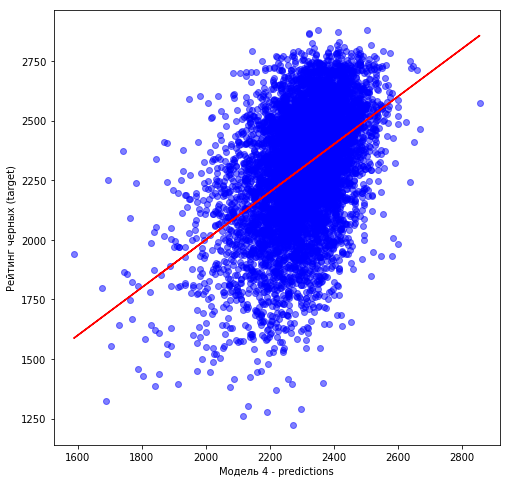

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(black_pred4,target_black4, color = 'b',alpha=0.5)
plt.xlabel('Модель 4 - predictions')
plt.ylabel('Рейтинг черных (target)')
# Линия тренда
z = np.polyfit(black_pred4,target_black4, 1)
p = np.poly1d(z)
plt.plot(black_pred4,p(black_pred4),"r")
plt.show()

In [25]:
mae4=mae(target_black4,black_pred4)
print ('MAE = {:.3f}'.format(mae4))
rmse4 = mse(target_black4, black_pred4)**0.5
print ('RMSE = {:.3f}'.format(rmse4))
corr_coef4 = pearsonr(target_black4,black_pred4)
print("Correlation coefficient = {:.3f}".format(corr_coef4[0]))

MAE = 182.049
RMSE = 228.385
Correlation coefficient = 0.452


In [27]:
output = output.append(pd.Series([str(lr_4), mae4, rmse4, corr_coef4[0],
                                  full_time4,'Обучение только на ничьих -> прогноз ретйтинга черных'], index=output.columns ),
                      ignore_index=True)
output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...
5,"LinearRegression(copy_X=True, fit_intercept=Tr...",182.048649,228.384992,0.451721,0.144,Обучение только на ничьих -> прогноз ретйтинга...


In [28]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 5. Обучение только на проигрышах белых -> прогноз ретйтинга белых

In [29]:
start5 = time.time()
lr_5 = LinearRegression()
features_white5 = features[features['Result']==0]
target_white5=target_white[target_white.index.isin(features_white5.index)]
print(features_white5.shape)
print(target_white5.shape)
lr_5.fit(features_white5, target_white5)
white_pred5 = lr_5.predict(features_white5)
full_time5=round(time.time() - start5,3)
print(full_time5, 'c')

(7474, 233)
(7474,)
0.152 c


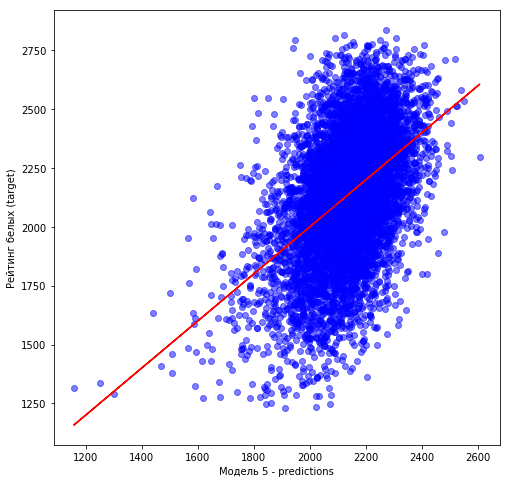

In [30]:
plt.figure(figsize=(8, 8))
plt.scatter(white_pred5,target_white5, color = 'b',alpha=0.5)
plt.xlabel('Модель 5 - predictions')
plt.ylabel('Рейтинг белых (target)')
# Линия тренда
z = np.polyfit(white_pred5,target_white5, 1)
p = np.poly1d(z)
plt.plot(white_pred5,p(white_pred5),"r")
plt.show()

In [31]:
mae5=mae(target_white5,white_pred5)
print ('MAE = {:.3f}'.format(mae5))
rmse5 = (mse(target_white5, white_pred5))**0.5
print ('RMSE = {:.3f}'.format(rmse5))
corr_coef5 = pearsonr(target_white5, white_pred5)
print("Correlation coefficient = {:.3f}".format(corr_coef5[0]))

MAE = 192.063
RMSE = 241.581
Correlation coefficient = 0.467


In [32]:
output = output.append(pd.Series([str(lr_5), mae5, rmse5, corr_coef5[0],
                                  full_time5,'Обучение только на проигрышах белых -> прогноз ретйтинга белых'], index=output.columns ),
                      ignore_index=True)
output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...
5,"LinearRegression(copy_X=True, fit_intercept=Tr...",182.048649,228.384992,0.451721,0.144,Обучение только на ничьих -> прогноз ретйтинга...
6,"LinearRegression(copy_X=True, fit_intercept=Tr...",192.062805,241.580990,0.467338,0.152,Обучение только на проигрышах белых -> прогноз...


#### 6. Обучение только на проигрышах черных -> прогноз ретйтинга черных

In [33]:
start6 = time.time()
lr_6 = LinearRegression()
features_black6 = features[features['Result']==1]
target_black6=target_black[target_black.index.isin(features_black6.index)]
print(features_black6.shape)
print(target_black6.shape)
lr_6.fit(features_black6, target_black6)
black_pred6 = lr_6.predict(features_black6)
full_time6=round(time.time() - start6,3)
print(full_time6, 'c')

(9651, 233)
(9651,)
0.175 c


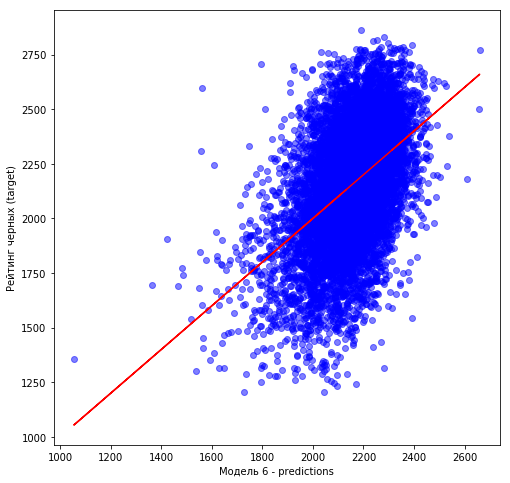

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(black_pred6,target_black6, color = 'b',alpha=0.5)
plt.xlabel('Модель 6 - predictions')
plt.ylabel('Рейтинг черных (target)')
# Линия тренда
z = np.polyfit(black_pred6,target_black6, 1)
p = np.poly1d(z)
plt.plot(black_pred6,p(black_pred6),"r")
plt.show()

In [35]:
mae6=mae(target_black6,black_pred6)
print ('MAE = {:.3f}'.format(mae6))
rmse6 = mse(target_black6, black_pred6)**0.5
print ('RMSE = {:.3f}'.format(rmse6))
corr_coef6 = pearsonr(target_black6, black_pred6)
print("Correlation coefficient = {:.3f}".format(corr_coef6[0]))

MAE = 193.242
RMSE = 242.404
Correlation coefficient = 0.462


In [36]:
output = output.append(pd.Series([str(lr_6), mae6, rmse6, corr_coef6[0],
                                  full_time6,'Обучение только на проигрышах черных -> прогноз ретйтинга черных'], index=output.columns ),
                      ignore_index=True)
output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...
5,"LinearRegression(copy_X=True, fit_intercept=Tr...",182.048649,228.384992,0.451721,0.144,Обучение только на ничьих -> прогноз ретйтинга...
6,"LinearRegression(copy_X=True, fit_intercept=Tr...",192.062805,241.580990,0.467338,0.152,Обучение только на проигрышах белых -> прогноз...
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",193.242293,242.404488,0.461618,0.175,Обучение только на проигрышах черных -> прогно...


In [37]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 7. Объединение/усреднение моделей

#### 8. Обучение на среднем ЭЛО

In [38]:
start8 = time.time()
lr_8 = LinearRegression()
lr_8.fit(features, target_mean)
mean_pred = lr_8.predict(features)
full_time8=round(time.time() - start8,3)
print(full_time8, 'c')

0.347 c


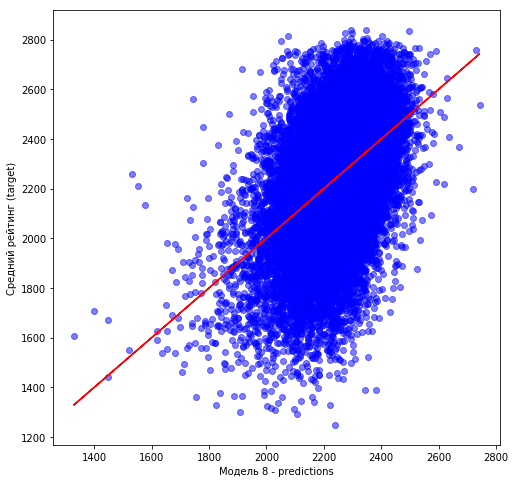

In [39]:
plt.figure(figsize=(8, 8))
plt.scatter(mean_pred,target_mean, color = 'b',alpha=0.5)
plt.xlabel('Модель 8 - predictions')
plt.ylabel('Средний рейтинг (target)')
# Линия тренда
z = np.polyfit(mean_pred,target_mean, 1)
p = np.poly1d(z)
plt.plot(mean_pred,p(mean_pred),"r")
plt.show()

In [41]:
mae8=mae(target_mean,mean_pred)
print ('MAE = {:.3f}'.format(mae8))
rmse8 = (mse(target_mean, mean_pred))**0.5
print ('RMSE = {:.3f}'.format(rmse8))
corr_coef8 = pearsonr(target_mean, mean_pred)
print("Correlation coefficient = {:.3f}".format(corr_coef8[0]))

MAE = 171.079
RMSE = 215.522
Correlation coefficient = 0.461


In [42]:
output = output.append(pd.Series([str(lr_8), mae8,rmse8, 
                                  corr_coef8[0],full_time8,'Обучение на среднем ЭЛО'],
                                 index=output.columns ),
                      ignore_index=True)

output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...
5,"LinearRegression(copy_X=True, fit_intercept=Tr...",182.048649,228.384992,0.451721,0.144,Обучение только на ничьих -> прогноз ретйтинга...
6,"LinearRegression(copy_X=True, fit_intercept=Tr...",192.062805,241.580990,0.467338,0.152,Обучение только на проигрышах белых -> прогноз...
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",193.242293,242.404488,0.461618,0.175,Обучение только на проигрышах черных -> прогно...
8,"LinearRegression(copy_X=True, fit_intercept=Tr...",171.079101,215.522294,0.461243,0.347,Обучение на среднем ЭЛО


In [43]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 9. Обучение на разнице ЭЛО

In [44]:
start9 = time.time()
lr_9 = LinearRegression()
lr_9.fit(features, target_diff)
diff_pred = lr_9.predict(features)
full_time9=round(time.time() - start9,3)
print(full_time9, 'c')

0.378 c


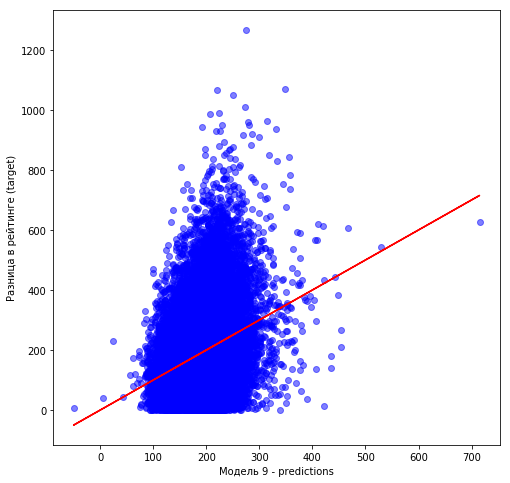

In [50]:
plt.figure(figsize=(8, 8))
plt.scatter(diff_pred,target_diff, color = 'b',alpha=0.5)
plt.xlabel('Модель 9 - predictions')
plt.ylabel('Разница в рейтинге (target)')
# Линия тренда
z = np.polyfit(diff_pred,target_diff, 1)
p = np.poly1d(z)
plt.plot(diff_pred,p(diff_pred),"r")
plt.show()

In [47]:
mae9=mae(target_diff,diff_pred)
print ('MAE = {:.3f}'.format(mae9))
rmse9 = (mse(target_diff, diff_pred))**0.5
print ('RMSE = {:.3f}'.format(rmse9))
corr_coef9 = pearsonr(target_diff,diff_pred)
print("Correlation coefficient = {:.3f}".format(corr_coef9[0]))

MAE = 100.071
RMSE = 129.889
Correlation coefficient = 0.305


In [48]:
output = output.append(pd.Series([str(lr_9), mae9,rmse9, 
                                  corr_coef9[0],full_time9,'Обучение на разнице в рейтинге'],
                                 index=output.columns ),
                      ignore_index=True)

output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...
5,"LinearRegression(copy_X=True, fit_intercept=Tr...",182.048649,228.384992,0.451721,0.144,Обучение только на ничьих -> прогноз ретйтинга...
6,"LinearRegression(copy_X=True, fit_intercept=Tr...",192.062805,241.580990,0.467338,0.152,Обучение только на проигрышах белых -> прогноз...
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",193.242293,242.404488,0.461618,0.175,Обучение только на проигрышах черных -> прогно...
8,"LinearRegression(copy_X=True, fit_intercept=Tr...",171.079101,215.522294,0.461243,0.347,Обучение на среднем ЭЛО
9,"LinearRegression(copy_X=True, fit_intercept=Tr...",100.070526,129.888906,0.304848,0.378,Обучение на разнице в рейтинге


In [49]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 10. Обучение на сумме ЭЛО

In [53]:
start10 = time.time()
lr_10 = LinearRegression()
lr_10.fit(features, target_sum)
sum_pred = lr_10.predict(features)
full_time10=round(time.time() - start10,3)
print(full_time10, 'c')

0.358 c


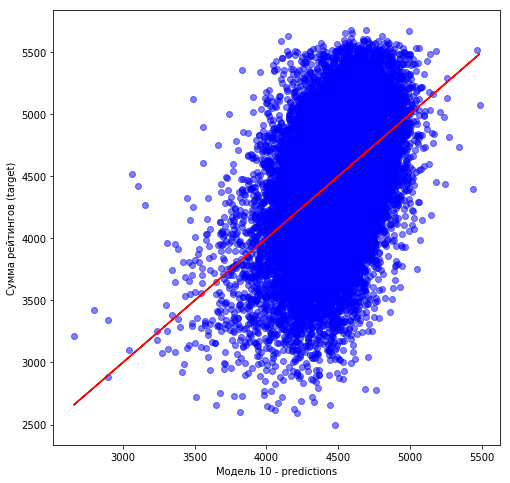

In [54]:
plt.figure(figsize=(8, 8))
plt.scatter(sum_pred,target_sum, color = 'b',alpha=0.5)
plt.xlabel('Модель 10 - predictions')
plt.ylabel('Сумма рейтингов (target)')
# Линия тренда
z = np.polyfit(sum_pred,target_sum, 1)
p = np.poly1d(z)
plt.plot(sum_pred,p(sum_pred),"r")
plt.show()

In [55]:
mae10=mae(target_sum,sum_pred)
print ('MAE = {:.3f}'.format(mae10))
rmse10 = (mse(target_sum, sum_pred))**0.5
print ('RMSE = {:.3f}'.format(rmse10))
corr_coef10 = pearsonr(target_sum,sum_pred)
print("Correlation coefficient = {:.3f}".format(corr_coef10[0]))

MAE = 342.161
RMSE = 431.050
Correlation coefficient = 0.461


In [56]:
output = output.append(pd.Series([str(lr_10), mae10,rmse10, 
                                  corr_coef10[0],full_time10,'Обучение на сумме рейтингов'],
                                 index=output.columns ),
                      ignore_index=True)

output

,Модель,MAE,RMSE,Коэффициент корр. Пирсона,Время работы (c),Комментарий
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",186.539067,234.559134,0.486111,0.362,Обучение на полном набооре -> прогноз рейтинго...
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",189.358443,237.420124,0.483303,0.362,Обучение на полном набооре -> прогноз рейтинго...
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",175.593949,221.353796,0.453718,0.153,Обучение только на победах белых -> прогноз ре...
3,"LinearRegression(copy_X=True, fit_intercept=Tr...",176.326439,221.767050,0.461520,0.216,Обучение только на победах черных -> прогноз р...
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",177.431734,224.595199,0.464714,0.137,Обучение только на ничьих -> прогноз ретйтинга...
5,"LinearRegression(copy_X=True, fit_intercept=Tr...",182.048649,228.384992,0.451721,0.144,Обучение только на ничьих -> прогноз ретйтинга...
6,"LinearRegression(copy_X=True, fit_intercept=Tr...",192.062805,241.580990,0.467338,0.152,Обучение только на проигрышах белых -> прогноз...
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",193.242293,242.404488,0.461618,0.175,Обучение только на проигрышах черных -> прогно...
8,"LinearRegression(copy_X=True, fit_intercept=Tr...",171.079101,215.522294,0.461243,0.347,Обучение на среднем ЭЛО
9,"LinearRegression(copy_X=True, fit_intercept=Tr...",100.070526,129.888906,0.304848,0.378,Обучение на разнице в рейтинге


In [57]:
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)

#### 11. Усреднение моделей выше

In [64]:
white_elos = mean_pred
black_elos = diff_pred / 2
list(zip(white_elos,black_elos))[:5]

[(2367.354764983913, 67.4835375091381),
 (2231.2839895682628, 107.63354409469852),
 (2224.1012407243697, 102.7736051525025),
 (2132.6513472580555, 141.90908747084507),
 (2359.29918055904, 62.448068641653215)]